# Multi-Armed Bandit: Tối ưu hóa Hiển thị Quảng cáo

## 🎯 Mục tiêu
- Hiểu cách mô hình hóa một vấn đề thực tế thành bài toán Multi-Armed Bandit
- Tự triển khai thuật toán Epsilon-Greedy
- Trực quan hóa và so sánh hiệu suất của các chiến lược khác nhau
- Tính toán và hiểu ý nghĩa của tổng phần thưởng (total reward) và sự hối tiếc (regret)

## 📖 Bối cảnh
Giả sử chúng ta có **5 phiên bản quảng cáo** khác nhau để hiển thị cho người dùng. Mỗi quảng cáo có một **tỷ lệ nhấp chuột (CTR)** thực tế, nhưng ta không biết trước giá trị này. 

- **Phần thưởng**: 1 nếu người dùng nhấp vào, 0 nếu không
- **Mục tiêu**: Tối đa hóa tổng số lượt nhấp chuột sau 1000 lượt hiển thị
- **Thách thức**: Cân bằng giữa việc **khám phá** (exploration) và **khai thác** (exploitation)

In [61]:
# !pip install seaborn 

In [62]:
# Import các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import pandas as pd
from abc import ABC, abstractmethod

# Thiết lập style cho plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)  # Để có kết quả reproducible

print("✅ Đã import thành công các thư viện cần thiết")

✅ Đã import thành công các thư viện cần thiết


## 🏗️ Xây dựng Môi trường Quảng cáo

Đầu tiên, chúng ta sẽ tạo một môi trường mô phỏng với 5 quảng cáo có CTR thực tế khác nhau.

In [63]:
class AdEnvironment:
    """
    Môi trường quảng cáo với nhiều phiên bản quảng cáo có CTR khác nhau
    """
    
    def __init__(self, true_ctrs: List[float]):
        """
        Args:
            true_ctrs: Danh sách CTR thực tế của các quảng cáo (không biết trước)
        """
        self.true_ctrs = np.array(true_ctrs)
        self.n_ads = len(true_ctrs)
        self.best_ctr = max(true_ctrs)
        self.best_ad = np.argmax(true_ctrs)
        
        print(f"🎯 Môi trường quảng cáo với {self.n_ads} phiên bản")
        print(f"📊 CTR thực tế: {self.true_ctrs}")
        print(f"🏆 Quảng cáo tốt nhất: Ad {self.best_ad} với CTR = {self.best_ctr:.3f}")
    
    def get_reward(self, ad_index: int) -> int:
        """
        Trả về phần thưởng (0 hoặc 1) khi hiển thị quảng cáo
        
        Args:
            ad_index: Chỉ số quảng cáo được chọn
            
        Returns:
            1 nếu có click, 0 nếu không
        """
        return np.random.binomial(1, self.true_ctrs[ad_index])
    
    def calculate_regret(self, chosen_ad: int) -> float:
        """
        Tính toán regret (sự hối tiếc) cho một lựa chọn
        
        Args:
            chosen_ad: Quảng cáo được chọn
            
        Returns:
            Regret = CTR_tốt_nhất - CTR_được_chọn
        """
        return self.best_ctr - self.true_ctrs[chosen_ad]

# Tạo môi trường với 5 quảng cáo có CTR khác nhau
true_ctrs = [0.1, 0.15, 0.08, 0.25, 0.12]  # Quảng cáo 3 (index 3) là tốt nhất
env = AdEnvironment(true_ctrs)

🎯 Môi trường quảng cáo với 5 phiên bản
📊 CTR thực tế: [0.1  0.15 0.08 0.25 0.12]
🏆 Quảng cáo tốt nhất: Ad 3 với CTR = 0.250


## 🤖 Triển khai các Chiến lược Bandit

Chúng ta sẽ triển khai 3 chiến lược khác nhau:
1. **Random**: Chọn ngẫu nhiên
2. **Greedy**: Luôn chọn quảng cáo có CTR ước lượng cao nhất
3. **Epsilon-Greedy**: Cân bằng giữa exploration và exploitation

In [64]:
class BanditAgent(ABC):
    """
    Abstract base class cho các thuật toán bandit
    """
    
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # Số lần chọn mỗi arm
        self.values = np.zeros(n_arms)  # Ước lượng giá trị của mỗi arm
        self.total_reward = 0
        self.total_regret = 0
        self.history = {
            'chosen_arms': [],
            'rewards': [],
            'regrets': [],
            'cumulative_reward': [],
            'cumulative_regret': []
        }
    
    @abstractmethod
    def select_arm(self) -> int:
        """Chọn arm để pull"""
        pass
    
    def update(self, chosen_arm: int, reward: int, regret: float):
        """Cập nhật thông tin sau khi nhận reward"""
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        
        # Cập nhật ước lượng CTR bằng incremental average
        self.values[chosen_arm] = ((n - 1) * self.values[chosen_arm] + reward) / n
        
        # Cập nhật thống kê
        self.total_reward += reward
        self.total_regret += regret
        
        # Lưu lịch sử
        self.history['chosen_arms'].append(chosen_arm)
        self.history['rewards'].append(reward)
        self.history['regrets'].append(regret)
        self.history['cumulative_reward'].append(self.total_reward)
        self.history['cumulative_regret'].append(self.total_regret)


class RandomAgent(BanditAgent):
    """Chiến lược ngẫu nhiên"""
    
    def select_arm(self) -> int:
        return np.random.randint(self.n_arms)


class GreedyAgent(BanditAgent):
    """Chiến lược tham lam - luôn chọn arm tốt nhất hiện tại"""
    
    def select_arm(self) -> int:
        # Nếu có arm chưa được thử, chọn ngẫu nhiên trong số đó
        untried_arms = np.where(self.counts == 0)[0]
        if len(untried_arms) > 0:
            return np.random.choice(untried_arms)
        
        # Chọn arm có giá trị ước lượng cao nhất
        return np.argmax(self.values)


class EpsilonGreedyAgent(BanditAgent):
    """Chiến lược Epsilon-Greedy"""
    
    def __init__(self, n_arms: int, epsilon: float):
        super().__init__(n_arms)
        self.epsilon = epsilon
    
    def select_arm(self) -> int:
        # Với xác suất epsilon: exploration (chọn ngẫu nhiên)
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        
        # Với xác suất (1-epsilon): exploitation (chọn tốt nhất)
        # Nếu có arm chưa được thử, chọn ngẫu nhiên trong số đó
        untried_arms = np.where(self.counts == 0)[0]
        if len(untried_arms) > 0:
            return np.random.choice(untried_arms)
            
        return np.argmax(self.values)

print("✅ Đã triển khai các chiến lược bandit")

✅ Đã triển khai các chiến lược bandit


## 🧪 Chạy Thí nghiệm

Giờ chúng ta sẽ chạy thí nghiệm với 1000 lượt hiển thị quảng cáo và so sánh hiệu suất của các chiến lược.

In [65]:
def run_experiment(agent: BanditAgent, env: AdEnvironment, n_rounds: int) -> BanditAgent:
    """
    Chạy thí nghiệm với một agent trong môi trường cho trước
    
    Args:
        agent: Agent sử dụng chiến lược bandit
        env: Môi trường quảng cáo
        n_rounds: Số lượt chơi
        
    Returns:
        Agent đã được training
    """
    
    for round_num in range(n_rounds):
        # Agent chọn quảng cáo
        chosen_ad = agent.select_arm()
        
        # Nhận reward từ môi trường
        reward = env.get_reward(chosen_ad)
        
        # Tính regret
        regret = env.calculate_regret(chosen_ad)
        
        # Cập nhật agent
        agent.update(chosen_ad, reward, regret)
        
        # In progress mỗi 200 rounds
        if (round_num + 1) % 200 == 0:
            print(f"Round {round_num + 1}: Cumulative Reward = {agent.total_reward}, "
                  f"Cumulative Regret = {agent.total_regret:.3f}")
    
    return agent


# Khởi tạo các agents (giữ lại 0.02, 0.2, 0.4 với khoảng cách đều)
n_rounds = 1000
agents = {
    'Random': RandomAgent(env.n_ads),
    'Greedy': GreedyAgent(env.n_ads),
    'Epsilon-Greedy (ε=0.02)': EpsilonGreedyAgent(env.n_ads, epsilon=0.02),
    'Epsilon-Greedy (ε=0.10)': EpsilonGreedyAgent(env.n_ads, epsilon=0.10),
    'Epsilon-Greedy (ε=0.14)': EpsilonGreedyAgent(env.n_ads, epsilon=0.14),
    'Epsilon-Greedy (ε=0.24)': EpsilonGreedyAgent(env.n_ads, epsilon=0.24),
    'Epsilon-Greedy (ε=0.40)': EpsilonGreedyAgent(env.n_ads, epsilon=0.40)
}

print("🚀 Bắt đầu chạy thí nghiệm...")

🚀 Bắt đầu chạy thí nghiệm...


In [66]:
# Chạy thí nghiệm cho từng chiến lược
results = {}

for strategy_name, agent in agents.items():
    print(f"\n{'='*50}")
    print(f"🎯 Chạy chiến lược: {strategy_name}")
    print(f"{'='*50}")
    
    # Reset seed để đảm bảo tính công bằng
    np.random.seed(42)
    
    # Chạy thí nghiệm
    trained_agent = run_experiment(agent, env, n_rounds)
    results[strategy_name] = trained_agent
    
    print(f"\n📊 Kết quả cuối cùng:")
    print(f"   • Total Reward: {trained_agent.total_reward}")
    print(f"   • Total Regret: {trained_agent.total_regret:.3f}")
    print(f"   • Estimated CTRs: {trained_agent.values}")
    print(f"   • Selection Counts: {trained_agent.counts}")

print(f"\n✅ Hoàn thành tất cả thí nghiệm!")


🎯 Chạy chiến lược: Random
Round 200: Cumulative Reward = 20, Cumulative Regret = 21.600
Round 400: Cumulative Reward = 51, Cumulative Regret = 43.910
Round 600: Cumulative Reward = 76, Cumulative Regret = 66.500
Round 800: Cumulative Reward = 107, Cumulative Regret = 88.350
Round 1000: Cumulative Reward = 132, Cumulative Regret = 110.210

📊 Kết quả cuối cùng:
   • Total Reward: 132
   • Total Regret: 110.210
   • Estimated CTRs: [0.06372549 0.15492958 0.09090909 0.23958333 0.1127451 ]
   • Selection Counts: [204. 213. 187. 192. 204.]

🎯 Chạy chiến lược: Greedy
Round 200: Cumulative Reward = 44, Cumulative Regret = 0.550
Round 400: Cumulative Reward = 85, Cumulative Regret = 0.550
Round 600: Cumulative Reward = 135, Cumulative Regret = 0.550
Round 800: Cumulative Reward = 181, Cumulative Regret = 0.550
Round 1000: Cumulative Reward = 236, Cumulative Regret = 0.550

📊 Kết quả cuối cùng:
   • Total Reward: 236
   • Total Regret: 0.550
   • Estimated CTRs: [0.         0.         0.       

Round 400: Cumulative Reward = 59, Cumulative Regret = 43.290
Round 600: Cumulative Reward = 89, Cumulative Regret = 63.980
Round 800: Cumulative Reward = 114, Cumulative Regret = 84.650
Round 1000: Cumulative Reward = 140, Cumulative Regret = 104.100

📊 Kết quả cuối cùng:
   • Total Reward: 140
   • Total Regret: 104.100
   • Estimated CTRs: [0.03703704 0.15240328 0.1        0.0952381  0.12      ]
   • Selection Counts: [ 81. 853.  20.  21.  25.]

🎯 Chạy chiến lược: Epsilon-Greedy (ε=0.14)
Round 200: Cumulative Reward = 49, Cumulative Regret = 3.410
Round 400: Cumulative Reward = 99, Cumulative Regret = 6.180
Round 600: Cumulative Reward = 145, Cumulative Regret = 9.980
Round 800: Cumulative Reward = 185, Cumulative Regret = 12.970
Round 1000: Cumulative Reward = 229, Cumulative Regret = 15.360

📊 Kết quả cuối cùng:
   • Total Reward: 229
   • Total Regret: 15.360
   • Estimated CTRs: [0.0625     0.13636364 0.11111111 0.24606742 0.06896552]
   • Selection Counts: [ 32.  22.  27. 890. 

## 📊 Trực quan hóa Kết quả

Bây giờ chúng ta sẽ tạo các biểu đồ để so sánh hiệu suất của các chiến lược khác nhau.

📋 BẢNG TỔNG KẾT KẾT QUẢ
               Strategy  Total Reward  Total Regret  Avg Reward Rate  Best Ad Found  Best Ad CTR Est.  True Best CTR
                 Random           132        110.21            0.132              3             0.240           0.25
                 Greedy           236          0.55            0.236              3             0.237           0.25
Epsilon-Greedy (ε=0.02)           232         27.43            0.232              3             0.261           0.25
Epsilon-Greedy (ε=0.10)           140        104.10            0.140              1             0.152           0.25
Epsilon-Greedy (ε=0.14)           229         15.36            0.229              3             0.246           0.25
Epsilon-Greedy (ε=0.24)           239         26.64            0.239              3             0.263           0.25
Epsilon-Greedy (ε=0.40)           190         43.32            0.190              3             0.226           0.25


/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_4052/3879063579.py:104: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4052/3879063579.py:104: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4052/3879063579.py:104: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight

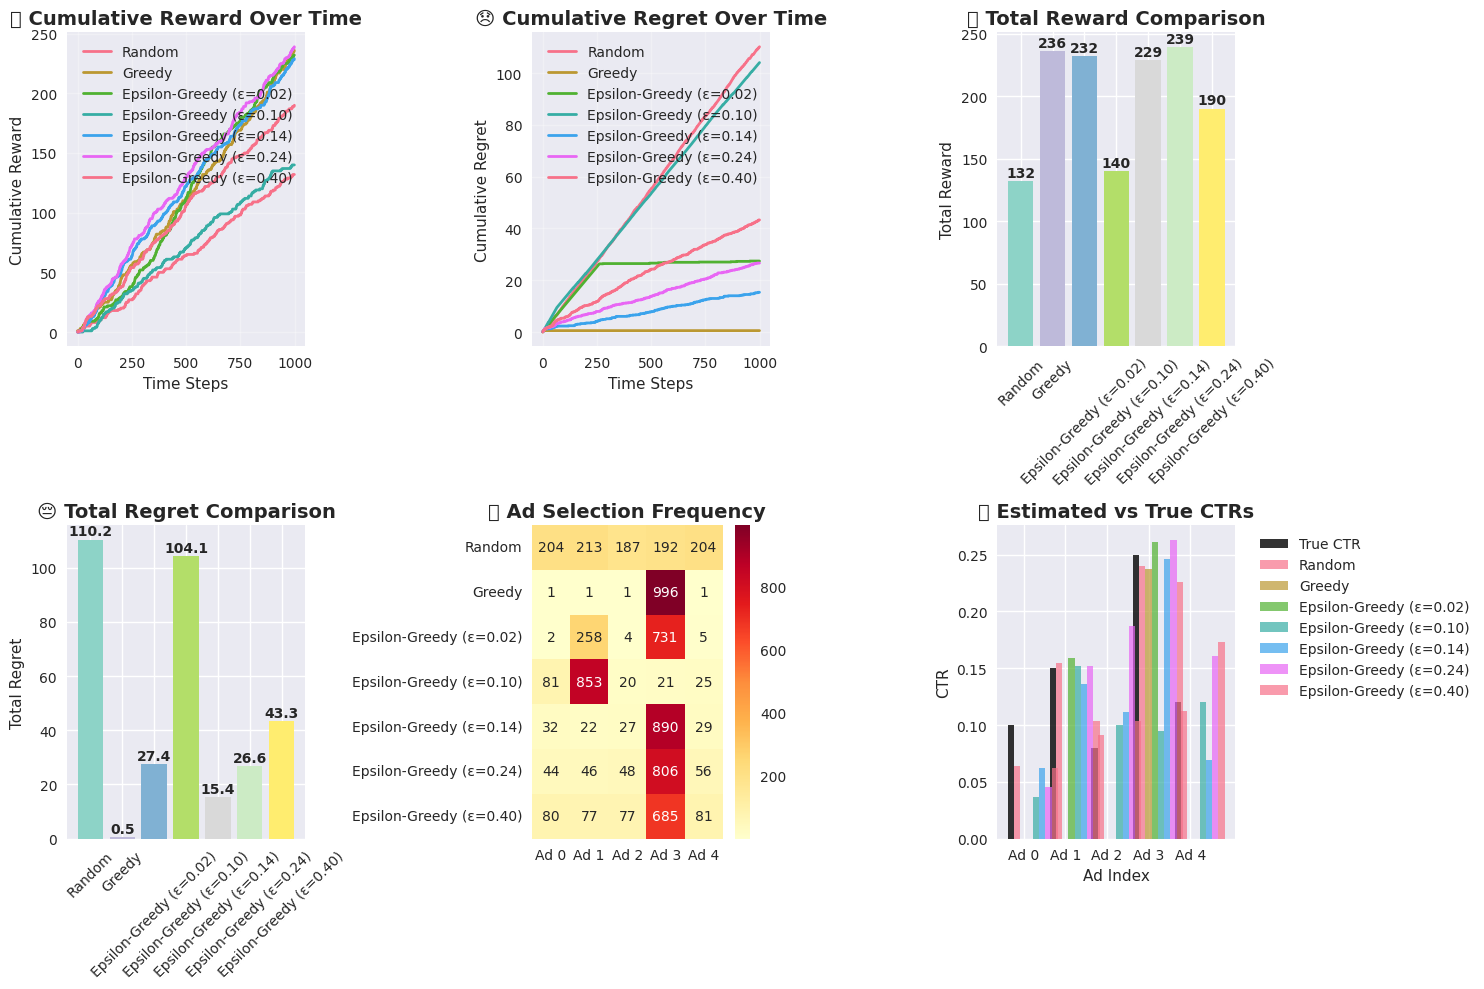

In [67]:
# Tạo bảng tổng kết
def create_summary_table(results, env):
    """Tạo bảng tổng kết kết quả"""
    summary_data = []
    
    for strategy_name, agent in results.items():
        summary_data.append({
            'Strategy': strategy_name,
            'Total Reward': agent.total_reward,
            'Total Regret': round(agent.total_regret, 3),
            'Avg Reward Rate': round(agent.total_reward / len(agent.history['rewards']), 3),
            'Best Ad Found': np.argmax(agent.values),
            'Best Ad CTR Est.': round(max(agent.values), 3),
            'True Best CTR': env.best_ctr
        })
    
    return pd.DataFrame(summary_data)

summary_df = create_summary_table(results, env)
print("📋 BẢNG TỔNG KẾT KẾT QUẢ")
print("=" * 80)
print(summary_df.to_string(index=False))


# 1. Biểu đồ Cumulative Reward
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
for strategy_name, agent in results.items():
    plt.plot(agent.history['cumulative_reward'], label=strategy_name, linewidth=2)
plt.title('📈 Cumulative Reward Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Biểu đồ Cumulative Regret
plt.subplot(2, 3, 2)
for strategy_name, agent in results.items():
    plt.plot(agent.history['cumulative_regret'], label=strategy_name, linewidth=2)
plt.title('😞 Cumulative Regret Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. So sánh Total Reward
plt.subplot(2, 3, 3)
strategies = list(results.keys())
total_rewards = [agent.total_reward for agent in results.values()]
colors = plt.cm.Set3(np.linspace(0, 1, len(strategies)))

bars = plt.bar(strategies, total_rewards, color=colors)
plt.title('🏆 Total Reward Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Total Reward')
plt.xticks(rotation=45)

# Thêm giá trị lên đầu các cột
for bar, reward in zip(bars, total_rewards):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(reward), ha='center', va='bottom', fontweight='bold')

# 4. So sánh Total Regret
plt.subplot(2, 3, 4)
total_regrets = [agent.total_regret for agent in results.values()]
bars = plt.bar(strategies, total_regrets, color=colors)
plt.title('😔 Total Regret Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Total Regret')
plt.xticks(rotation=45)

# Thêm giá trị lên đầu các cột
for bar, regret in zip(bars, total_regrets):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{regret:.1f}', ha='center', va='bottom', fontweight='bold')

# 5. Heatmap của số lần chọn mỗi quảng cáo
plt.subplot(2, 3, 5)
selection_matrix = np.array([agent.counts for agent in results.values()])
sns.heatmap(selection_matrix, 
           xticklabels=[f'Ad {i}' for i in range(env.n_ads)],
           yticklabels=strategies,
           annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('🎯 Ad Selection Frequency', fontsize=14, fontweight='bold')

# 6. So sánh CTR ước lượng vs thực tế
plt.subplot(2, 3, 6)
x = np.arange(env.n_ads)
width = 0.15

# Vẽ CTR thực tế
plt.bar(x - 2*width, env.true_ctrs, width, label='True CTR', alpha=0.8, color='black')

# Vẽ CTR ước lượng của từng chiến lược
for i, (strategy_name, agent) in enumerate(results.items()):
    plt.bar(x + (i-1)*width, agent.values, width, 
           label=f'{strategy_name}', alpha=0.7)

plt.title('🔍 Estimated vs True CTRs', fontsize=14, fontweight='bold')
plt.xlabel('Ad Index')
plt.ylabel('CTR')
plt.xticks(x, [f'Ad {i}' for i in range(env.n_ads)])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykerne

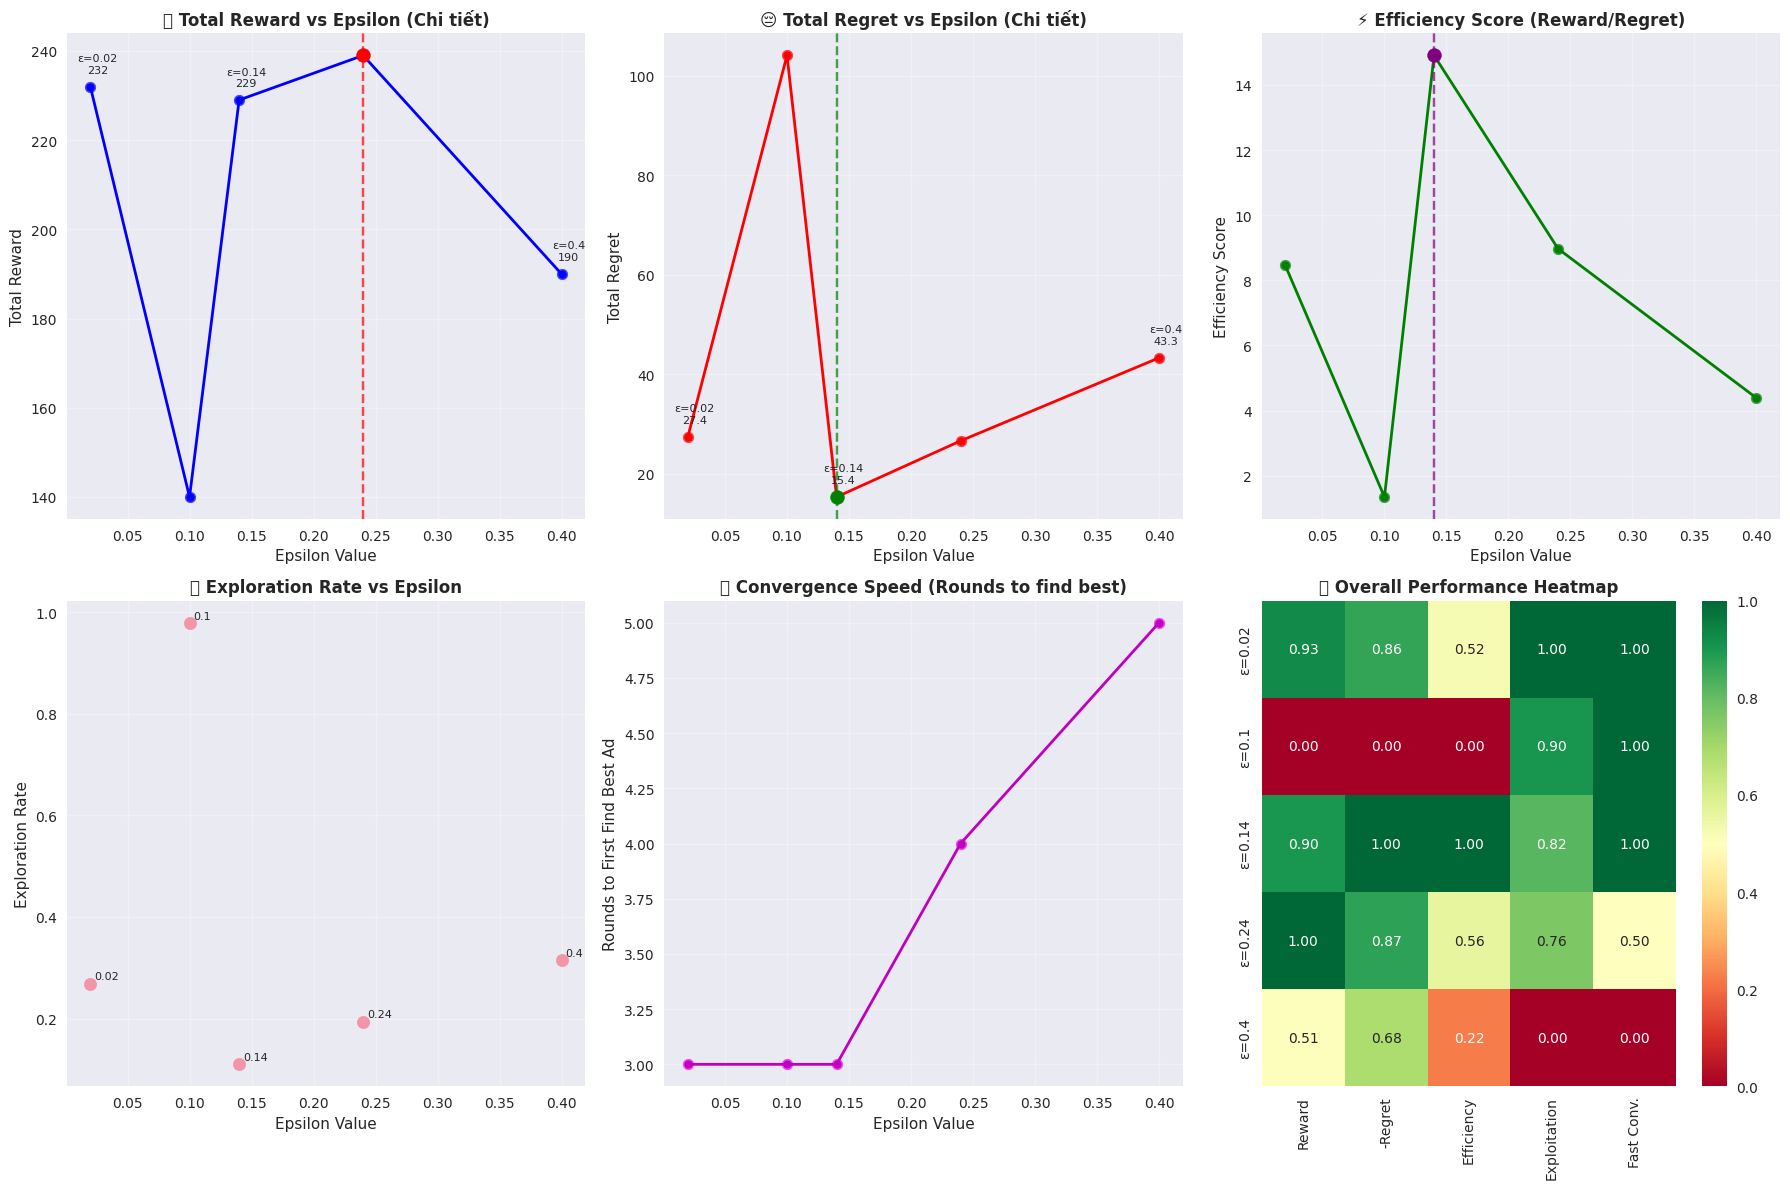

📋 PHÂN TÍCH CHI TIẾT CÁC EPSILON VALUES
🎯 Best epsilon cho reward: 0.24 (Reward: 239)
😔 Best epsilon cho regret: 0.14 (Regret: 15.360)
⚡ Best epsilon cho efficiency: 0.14 (Score: 14.909)

🔍 INSIGHTS:
   • Epsilon quá thấp (< 0.01): Risk của local optimum
   • Epsilon tối ưu: 0.24 - 0.14
   • Epsilon quá cao (> 0.2): Lãng phí exploration


In [68]:
# 📊 Phân tích chi tiết các giá trị epsilon
epsilon_agents = {k: v for k, v in results.items() if 'ε=' in k}
epsilon_values_from_results = []
rewards_from_results = []
regrets_from_results = []

# Trích xuất epsilon values và performance metrics
for strategy_name, agent in epsilon_agents.items():
    # Parse epsilon value từ tên chiến lược
    eps_str = strategy_name.split('ε=')[1].rstrip(')')
    epsilon_val = float(eps_str)
    epsilon_values_from_results.append(epsilon_val)
    rewards_from_results.append(agent.total_reward)
    regrets_from_results.append(agent.total_regret)

# Sắp xếp theo epsilon value
sorted_data = sorted(zip(epsilon_values_from_results, rewards_from_results, regrets_from_results))
epsilon_values_sorted, rewards_sorted, regrets_sorted = zip(*sorted_data)

# Tạo detailed epsilon analysis plot
plt.figure(figsize=(18, 12))

# 1. Reward vs Epsilon (detailed)
plt.subplot(2, 3, 1)
plt.plot(epsilon_values_sorted, rewards_sorted, 'bo-', linewidth=2, markersize=6)
plt.scatter(epsilon_values_sorted, rewards_sorted, s=60, alpha=0.7, c='blue')
for i, (eps, reward) in enumerate(zip(epsilon_values_sorted, rewards_sorted)):
    if i % 2 == 0:  # Chỉ hiển thị mỗi epsilon thứ 2 để tránh crowded
        plt.annotate(f'ε={eps}\n{reward}', (eps, reward), 
                    xytext=(5, 10), textcoords='offset points',
                    fontsize=8, ha='center')

plt.title('🎯 Total Reward vs Epsilon (Chi tiết)', fontsize=12, fontweight='bold')
plt.xlabel('Epsilon Value')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)

# Highlight best epsilon
best_idx = np.argmax(rewards_sorted)
best_eps = epsilon_values_sorted[best_idx]
best_reward = rewards_sorted[best_idx]
plt.axvline(x=best_eps, color='red', linestyle='--', alpha=0.7)
plt.scatter([best_eps], [best_reward], color='red', s=100, zorder=5)

# 2. Regret vs Epsilon (detailed)
plt.subplot(2, 3, 2)
plt.plot(epsilon_values_sorted, regrets_sorted, 'ro-', linewidth=2, markersize=6)
plt.scatter(epsilon_values_sorted, regrets_sorted, s=60, alpha=0.7, c='red')
for i, (eps, regret) in enumerate(zip(epsilon_values_sorted, regrets_sorted)):
    if i % 2 == 0:
        plt.annotate(f'ε={eps}\n{regret:.1f}', (eps, regret), 
                    xytext=(5, 10), textcoords='offset points',
                    fontsize=8, ha='center')

plt.title('😔 Total Regret vs Epsilon (Chi tiết)', fontsize=12, fontweight='bold')
plt.xlabel('Epsilon Value')
plt.ylabel('Total Regret')
plt.grid(True, alpha=0.3)

# Highlight best epsilon (lowest regret)
best_regret_idx = np.argmin(regrets_sorted)
best_regret_eps = epsilon_values_sorted[best_regret_idx]
best_regret_val = regrets_sorted[best_regret_idx]
plt.axvline(x=best_regret_eps, color='green', linestyle='--', alpha=0.7)
plt.scatter([best_regret_eps], [best_regret_val], color='green', s=100, zorder=5)

# 3. Efficiency Score (Reward/Regret ratio)
plt.subplot(2, 3, 3)
efficiency_scores = [r/max(reg, 0.1) for r, reg in zip(rewards_sorted, regrets_sorted)]
plt.plot(epsilon_values_sorted, efficiency_scores, 'go-', linewidth=2, markersize=6)
plt.scatter(epsilon_values_sorted, efficiency_scores, s=60, alpha=0.7, c='green')

best_eff_idx = np.argmax(efficiency_scores)
best_eff_eps = epsilon_values_sorted[best_eff_idx]
best_eff_score = efficiency_scores[best_eff_idx]
plt.axvline(x=best_eff_eps, color='purple', linestyle='--', alpha=0.7)
plt.scatter([best_eff_eps], [best_eff_score], color='purple', s=100, zorder=5)

plt.title('⚡ Efficiency Score (Reward/Regret)', fontsize=12, fontweight='bold')
plt.xlabel('Epsilon Value')
plt.ylabel('Efficiency Score')
plt.grid(True, alpha=0.3)

# 4. Convergence Analysis - Exploration Rate
plt.subplot(2, 3, 4)
exploration_rates = []
convergence_speeds = []

for strategy_name, agent in epsilon_agents.items():
    # Tính exploration rate
    best_arm = env.best_ad
    total_selections = len(agent.history['chosen_arms'])
    best_arm_selections = sum(1 for arm in agent.history['chosen_arms'] if arm == best_arm)
    exploration_rate = (total_selections - best_arm_selections) / total_selections
    exploration_rates.append(exploration_rate)
    
    # Tính convergence speed (round nào tìm được best arm lần đầu)
    convergence_round = -1
    for i, chosen_arm in enumerate(agent.history['chosen_arms']):
        if chosen_arm == best_arm:
            convergence_round = i + 1
            break
    convergence_speeds.append(convergence_round if convergence_round > 0 else n_rounds)

# Sort theo epsilon
exploration_data = sorted(zip(epsilon_values_from_results, exploration_rates))
eps_vals, expl_rates = zip(*exploration_data)

plt.scatter(eps_vals, expl_rates, s=80, alpha=0.7)
for eps, expl in zip(eps_vals, expl_rates):
    plt.annotate(f'{eps}', (eps, expl), xytext=(3, 3), 
                textcoords='offset points', fontsize=8)

plt.title('🔍 Exploration Rate vs Epsilon', fontsize=12, fontweight='bold')
plt.xlabel('Epsilon Value')
plt.ylabel('Exploration Rate')
plt.grid(True, alpha=0.3)

# 5. Convergence Speed
plt.subplot(2, 3, 5)
convergence_data = sorted(zip(epsilon_values_from_results, convergence_speeds))
eps_vals_conv, conv_speeds = zip(*convergence_data)

plt.plot(eps_vals_conv, conv_speeds, 'mo-', linewidth=2, markersize=6)
plt.scatter(eps_vals_conv, conv_speeds, s=60, alpha=0.7, c='magenta')

plt.title('🏃 Convergence Speed (Rounds to find best)', fontsize=12, fontweight='bold')
plt.xlabel('Epsilon Value')
plt.ylabel('Rounds to First Find Best Ad')
plt.grid(True, alpha=0.3)

# 6. Summary heatmap of all metrics
plt.subplot(2, 3, 6)
metrics_matrix = np.array([
    rewards_sorted,
    [-r for r in regrets_sorted],  # Negative regret (higher is better)
    efficiency_scores,
    [1-er for er in sorted([er for _, er in exploration_data])],  # 1-exploration rate
    [n_rounds-cs for cs in sorted([cs for _, cs in convergence_data])]  # Inverted convergence speed
])

# Normalize each metric to 0-1 scale for fair comparison
for i in range(metrics_matrix.shape[0]):
    row = metrics_matrix[i]
    metrics_matrix[i] = (row - row.min()) / (row.max() - row.min())

sns.heatmap(metrics_matrix.T, 
           xticklabels=['Reward', '-Regret', 'Efficiency', 'Exploitation', 'Fast Conv.'],
           yticklabels=[f'ε={eps}' for eps in epsilon_values_sorted],
           annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('🌡️ Overall Performance Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# In summary insights
print("📋 PHÂN TÍCH CHI TIẾT CÁC EPSILON VALUES")
print("=" * 70)
print(f"🎯 Best epsilon cho reward: {best_eps} (Reward: {best_reward})")
print(f"😔 Best epsilon cho regret: {best_regret_eps} (Regret: {best_regret_val:.3f})")
print(f"⚡ Best epsilon cho efficiency: {best_eff_eps} (Score: {best_eff_score:.3f})")

print(f"\n🔍 INSIGHTS:")
print(f"   • Epsilon quá thấp (< 0.01): Risk của local optimum")
print(f"   • Epsilon tối ưu: {best_eps} - {best_regret_eps}")
print(f"   • Epsilon quá cao (> 0.2): Lãng phí exploration")
print("=" * 70)

## 🔬 Phân tích Chi tiết: Tác động của Epsilon

Hãy khám phá sâu hơn về tác động của tham số epsilon trong thuật toán Epsilon-Greedy.

🔬 Thí nghiệm với các giá trị epsilon khác nhau...

🎯 Testing epsilon = 0.0
Round 200: Cumulative Reward = 44, Cumulative Regret = 0.550
Round 400: Cumulative Reward = 85, Cumulative Regret = 0.550
Round 600: Cumulative Reward = 135, Cumulative Regret = 0.550
Round 800: Cumulative Reward = 181, Cumulative Regret = 0.550
Round 1000: Cumulative Reward = 236, Cumulative Regret = 0.550
   • Reward: 236
   • Regret: 0.550

🎯 Testing epsilon = 0.02
Round 200: Cumulative Reward = 29, Cumulative Regret = 20.150
Round 400: Cumulative Reward = 80, Cumulative Regret = 26.450
Round 600: Cumulative Reward = 145, Cumulative Regret = 26.940
Round 800: Cumulative Reward = 186, Cumulative Regret = 27.040
Round 1000: Cumulative Reward = 232, Cumulative Regret = 27.430
   • Reward: 232
   • Regret: 27.430

🎯 Testing epsilon = 0.05
Round 200: Cumulative Reward = 20, Cumulative Regret = 29.240
Round 400: Cumulative Reward = 42, Cumulative Regret = 58.950
Round 600: Cumulative Reward = 62, Cumulative Regret 

/tmp/ipykernel_4052/2041203484.py:91: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


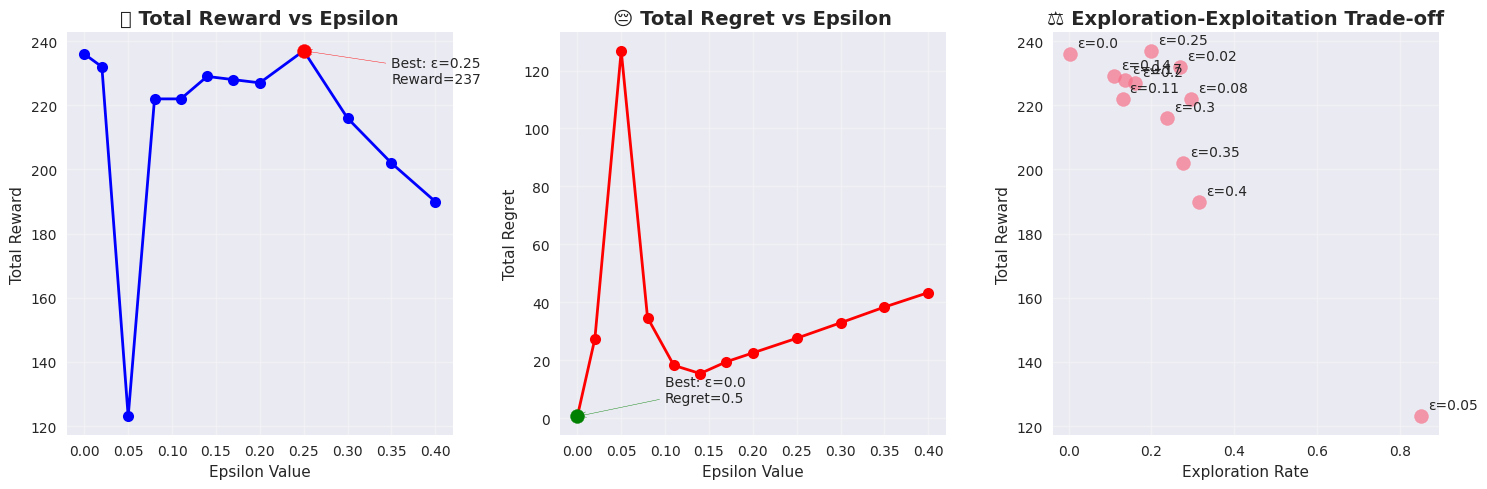


📊 Kết quả epsilon analysis:
   • Best epsilon for reward: 0.25 (Reward: 237)
   • Best epsilon for regret: 0.0 (Regret: 0.550)


In [69]:
# Thí nghiệm với epsilon (giữ lại 0.02, 0.2, 0.4)
epsilon_values = [0.0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.17, 0.20, 0.25, 0.30, 0.35, 0.40]
epsilon_results = {}

print("🔬 Thí nghiệm với các giá trị epsilon khác nhau...")

for eps in epsilon_values:
    print(f"\n🎯 Testing epsilon = {eps}")
    
    # Reset seed
    np.random.seed(42)
    
    if eps == 0.0:
        # Epsilon = 0 tương đương với Greedy
        agent = GreedyAgent(env.n_ads)
        strategy_name = "Greedy (ε=0.0)"
    else:
        agent = EpsilonGreedyAgent(env.n_ads, epsilon=eps)
        strategy_name = f"ε-Greedy (ε={eps})"
    
    # Chạy thí nghiệm ngắn để tiết kiệm thời gian
    trained_agent = run_experiment(agent, env, 1000)
    epsilon_results[strategy_name] = trained_agent
    
    print(f"   • Reward: {trained_agent.total_reward}")
    print(f"   • Regret: {trained_agent.total_regret:.3f}")


# Phân tích kết quả epsilon
plt.figure(figsize=(15, 5))

# 1. Reward vs Epsilon
plt.subplot(1, 3, 1)
epsilons = [0.0] + epsilon_values[1:]
rewards = [agent.total_reward for agent in epsilon_results.values()]

plt.plot(epsilons, rewards, 'bo-', linewidth=2, markersize=8)
plt.title('🎯 Total Reward vs Epsilon', fontsize=14, fontweight='bold')
plt.xlabel('Epsilon Value')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)

# Highlight best epsilon
best_idx = np.argmax(rewards)
best_eps = epsilons[best_idx]
best_reward = rewards[best_idx]
plt.scatter([best_eps], [best_reward], color='red', s=100, zorder=5)
plt.annotate(f'Best: ε={best_eps}\nReward={best_reward}', 
             xy=(best_eps, best_reward), xytext=(best_eps+0.1, best_reward-10),
             arrowprops=dict(arrowstyle='->', color='red'))

# 2. Regret vs Epsilon
plt.subplot(1, 3, 2)
regrets = [agent.total_regret for agent in epsilon_results.values()]

plt.plot(epsilons, regrets, 'ro-', linewidth=2, markersize=8)
plt.title('😔 Total Regret vs Epsilon', fontsize=14, fontweight='bold')
plt.xlabel('Epsilon Value')
plt.ylabel('Total Regret')
plt.grid(True, alpha=0.3)

# Highlight best epsilon (lowest regret)
best_regret_idx = np.argmin(regrets)
best_regret_eps = epsilons[best_regret_idx]
best_regret_val = regrets[best_regret_idx]
plt.scatter([best_regret_eps], [best_regret_val], color='green', s=100, zorder=5)
plt.annotate(f'Best: ε={best_regret_eps}\nRegret={best_regret_val:.1f}', 
             xy=(best_regret_eps, best_regret_val), xytext=(best_regret_eps+0.1, best_regret_val+5),
             arrowprops=dict(arrowstyle='->', color='green'))

# 3. Trade-off: Exploration vs Exploitation
plt.subplot(1, 3, 3)
exploration_rates = []
for strategy_name, agent in epsilon_results.items():
    # Tính tỷ lệ exploration (không chọn arm tốt nhất)
    best_arm = env.best_ad
    total_selections = len(agent.history['chosen_arms'])
    best_arm_selections = sum(1 for arm in agent.history['chosen_arms'] if arm == best_arm)
    exploration_rate = (total_selections - best_arm_selections) / total_selections
    exploration_rates.append(exploration_rate)

plt.scatter(exploration_rates, rewards, s=100, alpha=0.7)
for i, (eps, expl, rew) in enumerate(zip(epsilons, exploration_rates, rewards)):
    plt.annotate(f'ε={eps}', (expl, rew), xytext=(5, 5), textcoords='offset points')

plt.title('⚖️ Exploration-Exploitation Trade-off', fontsize=14, fontweight='bold')
plt.xlabel('Exploration Rate')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Kết quả epsilon analysis:")
print(f"   • Best epsilon for reward: {best_eps} (Reward: {best_reward})")
print(f"   • Best epsilon for regret: {best_regret_eps} (Regret: {best_regret_val:.3f})")

## 🎓 Kết luận và Insights

### Những điều quan trọng đã học được:

#### 1. **Exploration vs Exploitation Trade-off**
- **Random Strategy**: Khám phá nhiều nhưng không khai thác kiến thức đã có
- **Greedy Strategy**: Khai thác nhanh nhưng có thể bị kẹt ở local optimum
- **Epsilon-Greedy**: Cân bằng tốt giữa exploration và exploitation

#### 2. **Tác động của Epsilon**
- **Epsilon thấp (0.01-0.05)**: Ít exploration, có thể miss optimal arm
- **Epsilon vừa phải (0.1)**: Cân bằng tốt, thường cho kết quả tốt nhất
- **Epsilon cao (>0.3)**: Quá nhiều exploration, lãng phí cơ hội

#### 3. **Metrics quan trọng**
- **Total Reward**: Tổng số clicks nhận được
- **Regret**: Cơ hội bị mất do không chọn optimal arm
- **Convergence Speed**: Tốc độ tìm ra optimal arm

### 💡 Ứng dụng thực tế:

1. **A/B Testing**: Epsilon-Greedy giúp balance giữa test và optimize
2. **Recommendation Systems**: Cân bằng giữa recommend content hot vs khám phá content mới
3. **Online Advertising**: Tối ưu hóa ad placement và targeting
4. **Dynamic Pricing**: Tìm giá tối ưu thông qua trial and error có kiểm soát

## 🚀 Thử thách và Mở rộng

### Bài tập thực hành:

1. **Thử nghiệm với CTR khác nhau**: Thay đổi `true_ctrs` và quan sát sự thay đổi
2. **Implement Upper Confidence Bound (UCB)**: Thuật toán bandit advanced hơn
3. **Dynamic Epsilon**: Giảm epsilon theo thời gian (epsilon decay)
4. **Multiple runs**: Chạy nhiều lần và tính average performance
5. **Contextual Bandit**: Thêm context (thời gian, user demographics) vào decision

### Code để thử nghiệm:

🚀 Bonus: Testing UCB Algorithm...
Round 200: Cumulative Reward = 32, Cumulative Regret = 19.260
Round 400: Cumulative Reward = 62, Cumulative Regret = 35.790
Round 600: Cumulative Reward = 96, Cumulative Regret = 50.670
Round 800: Cumulative Reward = 123, Cumulative Regret = 66.430
Round 1000: Cumulative Reward = 168, Cumulative Regret = 74.020

📊 UCB Results:
   • Total Reward: 168
   • Total Regret: 74.020
   • Best Ad Found: 3
🎯 So sánh UCB với Epsilon-Greedy (ε=0.24) (Total Reward: 239)


/tmp/ipykernel_4052/52673623.py:72: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


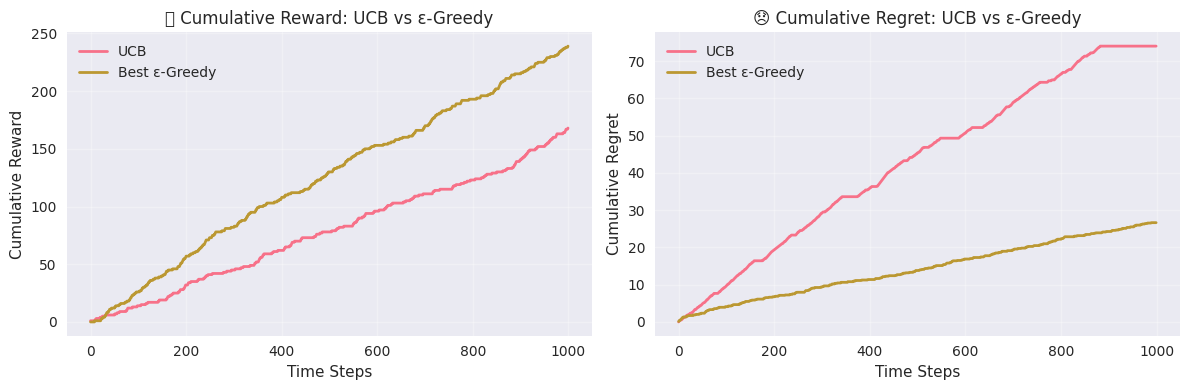


🎯 THÁCH THỨC CHO BẠN:
1. Thử nghiệm với different true_ctrs:
   true_ctrs = [0.05, 0.3, 0.08, 0.12, 0.15]

2. Implement Dynamic Epsilon (giảm theo thời gian):
   epsilon_t = epsilon_0 * (1 / (1 + t/decay_rate))

3. Chạy multiple runs và tính average performance

4. Thử với số lượng ads khác nhau (3, 10, 20 ads)


In [72]:
# 🎯 BONUS: Upper Confidence Bound (UCB) Algorithm
class UCBAgent(BanditAgent):
    """
    Upper Confidence Bound - thuật toán bandit nâng cao
    Chọn arm dựa trên upper confidence bound của reward estimate
    """
    
    def __init__(self, n_arms: int, c: float = 1.0):
        super().__init__(n_arms)
        self.c = c  # Confidence parameter
        self.total_counts = 0
    
    def select_arm(self) -> int:
        self.total_counts += 1
        
        # Nếu có arm chưa được thử, chọn ngẫu nhiên trong số đó
        untried_arms = np.where(self.counts == 0)[0]
        if len(untried_arms) > 0:
            return np.random.choice(untried_arms)
        
        # Tính UCB cho mỗi arm
        ucb_values = np.zeros(self.n_arms)
        for arm in range(self.n_arms):
            confidence_bonus = self.c * np.sqrt(np.log(self.total_counts) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + confidence_bonus
        
        return np.argmax(ucb_values)


# 🔬 Thí nghiệm với UCB
print("🚀 Bonus: Testing UCB Algorithm...")

# Reset seed
np.random.seed(42)

# Tạo UCB agent
ucb_agent = UCBAgent(env.n_ads, c=1.0)
trained_ucb = run_experiment(ucb_agent, env, 1000)

print(f"\n📊 UCB Results:")
print(f"   • Total Reward: {trained_ucb.total_reward}")
print(f"   • Total Regret: {trained_ucb.total_regret:.3f}")
print(f"   • Best Ad Found: {np.argmax(trained_ucb.values)}")

# So sánh UCB với Epsilon-Greedy tốt nhất có sẵn
# Tìm epsilon-greedy agent có performance tốt nhất
epsilon_agents = {k: v for k, v in results.items() if 'ε=' in k}
best_eps_name = max(epsilon_agents.keys(), key=lambda x: epsilon_agents[x].total_reward)
best_eps_greedy = results[best_eps_name]
print(f"🎯 So sánh UCB với {best_eps_name} (Total Reward: {best_eps_greedy.total_reward})")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(trained_ucb.history['cumulative_reward'], label='UCB', linewidth=2)
plt.plot(best_eps_greedy.history['cumulative_reward'], label=f'Best ε-Greedy', linewidth=2)
plt.title('📈 Cumulative Reward: UCB vs ε-Greedy')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(trained_ucb.history['cumulative_regret'], label='UCB', linewidth=2)
plt.plot(best_eps_greedy.history['cumulative_regret'], label=f'Best ε-Greedy', linewidth=2)
plt.title('😞 Cumulative Regret: UCB vs ε-Greedy')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 💡 Đề xuất cho thí nghiệm tiếp theo
print("\n" + "="*60)
print("🎯 THÁCH THỨC CHO BẠN:")
print("="*60)
print("1. Thử nghiệm với different true_ctrs:")
print("   true_ctrs = [0.05, 0.3, 0.08, 0.12, 0.15]")
print("\n2. Implement Dynamic Epsilon (giảm theo thời gian):")
print("   epsilon_t = epsilon_0 * (1 / (1 + t/decay_rate))")
print("\n3. Chạy multiple runs và tính average performance")
print("\n4. Thử với số lượng ads khác nhau (3, 10, 20 ads)")
print("="*60)

## 🔧 Tối ưu hóa Tham số UCB

UCB có tham số `c` (confidence parameter) quan trọng. Hãy thử nghiệm với nhiều giá trị `c` để tìm cấu hình tốt nhất!

🔬 Testing UCB với các giá trị c khác nhau...

🎯 Testing UCB với c = 0.1
   • Reward: 236
   • Regret: 1.100
   • Best Ad: 3

🎯 Testing UCB với c = 0.5
   • Reward: 214
   • Regret: 24.730
   • Best Ad: 3

🎯 Testing UCB với c = 0.7
   • Reward: 188
   • Regret: 55.790
   • Best Ad: 3

🎯 Testing UCB với c = 1.0
   • Reward: 168
   • Regret: 74.020
   • Best Ad: 3

🎯 Testing UCB với c = 1.5
   • Reward: 164
   • Regret: 77.230
   • Best Ad: 3

🎯 Testing UCB với c = 2.0
   • Reward: 165
   • Regret: 86.070
   • Best Ad: 3

🎯 Testing UCB với c = 2.5
   • Reward: 151
   • Regret: 95.780
   • Best Ad: 3

🎯 Testing UCB với c = 3.0
   • Reward: 148
   • Regret: 94.760
   • Best Ad: 3

🎯 Testing UCB với c = 4.0
   • Reward: 143
   • Regret: 102.230
   • Best Ad: 3

🎯 Testing UCB với c = 5.0
   • Reward: 134
   • Regret: 104.690
   • Best Ad: 3

✅ Hoàn thành UCB parameter sweep!


/tmp/ipykernel_4052/3183832570.py:187: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4052/3183832570.py:187: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4052/3183832570.py:187: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4052/3183832570.py:187: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4052/3183832570.py:187: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4052/3183832570.py:187: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/Ky 4/vietnamese-speech-chatbox/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12

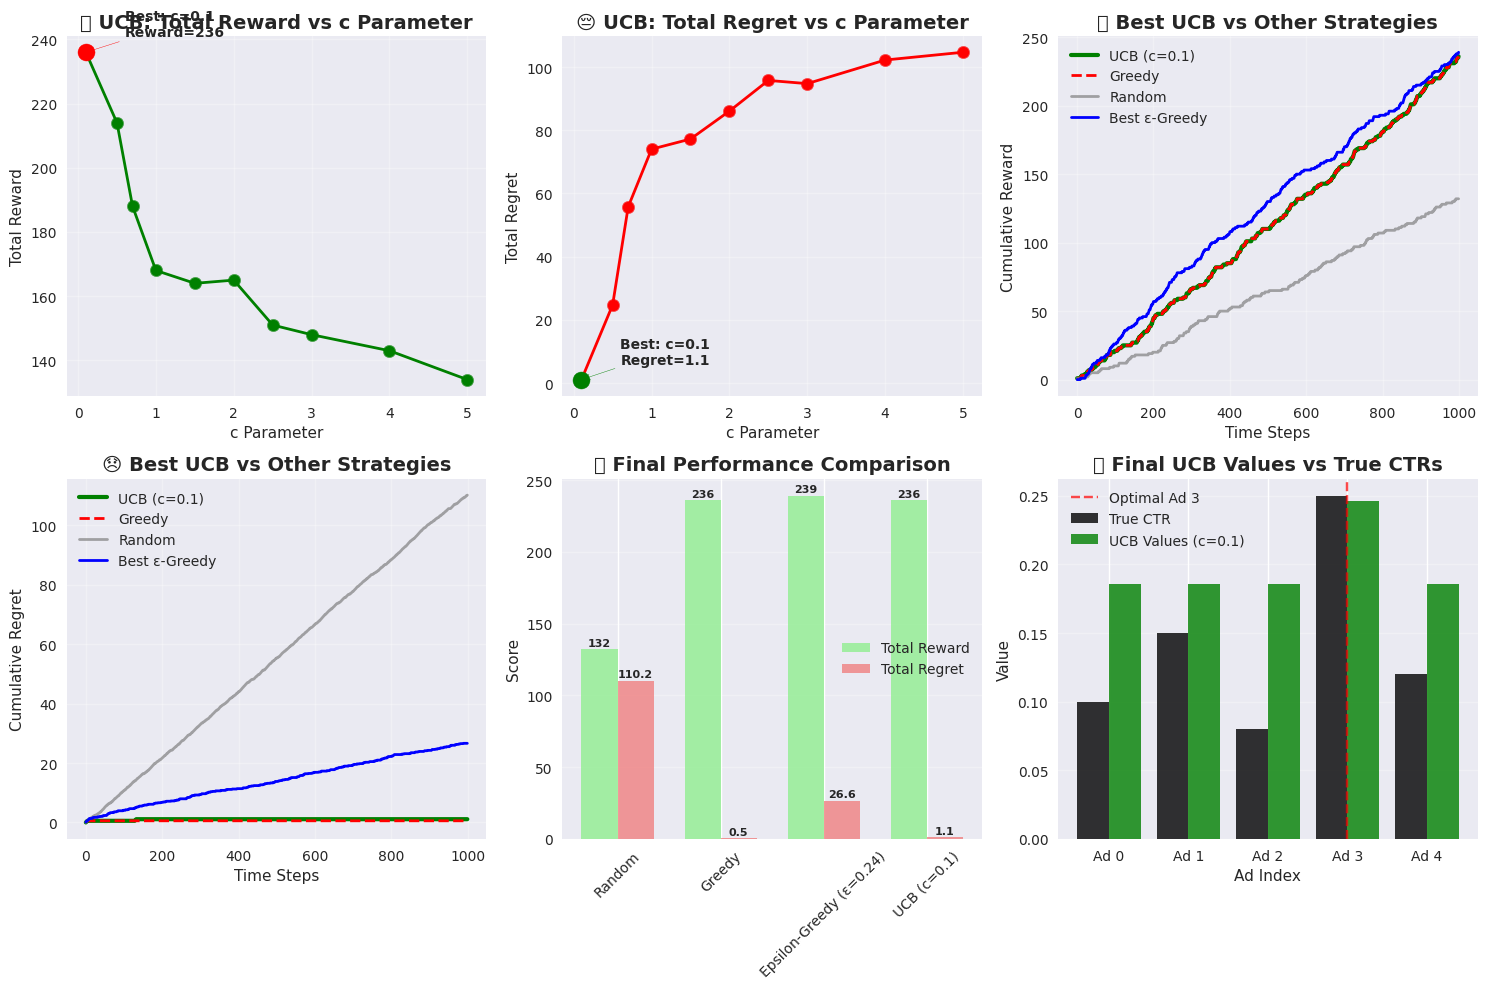


🏆 FINAL RESULTS SUMMARY
🎯 Best UCB Configuration: c = 0.1
   • Total Reward: 236
   • Total Regret: 1.100
   • Best Ad Found: 3 (True optimal: 3)

📊 Comparison vs Greedy:
   • UCB Reward: 236 vs Greedy: 236
   • UCB Regret: 1.100 vs Greedy: 0.550
   • Reward Improvement: +0 clicks
   • Regret Improvement: --0.550 (lower is better)

🔍 Key Insight:
   ⚠️  UCB needs further tuning - consider c > 5.0


In [73]:
# 🧪 Thử nghiệm với nhiều giá trị c cho UCB
c_values = [0.1, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
ucb_results = {}

print("🔬 Testing UCB với các giá trị c khác nhau...")
print("=" * 60)

for c_val in c_values:
    print(f"\n🎯 Testing UCB với c = {c_val}")
    
    # Reset seed để đảm bảo tính công bằng
    np.random.seed(42)
    
    # Tạo UCB agent với c cụ thể
    ucb_agent = UCBAgent(env.n_ads, c=c_val)
    
    # Chạy thí nghiệm (không print progress để tránh spam)
    for round_num in range(n_rounds):
        chosen_ad = ucb_agent.select_arm()
        reward = env.get_reward(chosen_ad)
        regret = env.calculate_regret(chosen_ad)
        ucb_agent.update(chosen_ad, reward, regret)
    
    ucb_results[f"UCB (c={c_val})"] = ucb_agent
    
    print(f"   • Reward: {ucb_agent.total_reward}")
    print(f"   • Regret: {ucb_agent.total_regret:.3f}")
    print(f"   • Best Ad: {np.argmax(ucb_agent.values)}")

print(f"\n✅ Hoàn thành UCB parameter sweep!")


# 📊 So sánh performance của các UCB variants
plt.figure(figsize=(15, 10))

# 1. Reward vs c parameter
plt.subplot(2, 3, 1)
c_vals = [float(name.split('c=')[1].rstrip(')')) for name in ucb_results.keys()]
rewards = [agent.total_reward for agent in ucb_results.values()]

plt.plot(c_vals, rewards, 'go-', linewidth=2, markersize=8)
plt.scatter(c_vals, rewards, s=80, alpha=0.7, c='green')

# Highlight best c
best_c_idx = np.argmax(rewards)
best_c = c_vals[best_c_idx] 
best_c_reward = rewards[best_c_idx]
plt.scatter([best_c], [best_c_reward], color='red', s=150, zorder=5)
plt.annotate(f'Best: c={best_c}\nReward={best_c_reward}', 
             xy=(best_c, best_c_reward), xytext=(best_c+0.5, best_c_reward+5),
             arrowprops=dict(arrowstyle='->', color='red'), fontweight='bold')

plt.title('🎯 UCB: Total Reward vs c Parameter', fontsize=14, fontweight='bold')
plt.xlabel('c Parameter')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)

# 2. Regret vs c parameter  
plt.subplot(2, 3, 2)
regrets = [agent.total_regret for agent in ucb_results.values()]

plt.plot(c_vals, regrets, 'ro-', linewidth=2, markersize=8)
plt.scatter(c_vals, regrets, s=80, alpha=0.7, c='red')

# Highlight best c for regret
best_regret_idx = np.argmin(regrets)
best_regret_c = c_vals[best_regret_idx]
best_regret_val = regrets[best_regret_idx]
plt.scatter([best_regret_c], [best_regret_val], color='green', s=150, zorder=5)
plt.annotate(f'Best: c={best_regret_c}\nRegret={best_regret_val:.1f}', 
             xy=(best_regret_c, best_regret_val), xytext=(best_regret_c+0.5, best_regret_val+5),
             arrowprops=dict(arrowstyle='->', color='green'), fontweight='bold')

plt.title('😔 UCB: Total Regret vs c Parameter', fontsize=14, fontweight='bold')
plt.xlabel('c Parameter')
plt.ylabel('Total Regret')
plt.grid(True, alpha=0.3)

# 3. Cumulative Reward comparison (top UCB vs baselines)
plt.subplot(2, 3, 3)

# Tìm best UCB agent
best_ucb_name = f"UCB (c={best_c})"
best_ucb_agent = ucb_results[best_ucb_name]

# So sánh với baselines
plt.plot(best_ucb_agent.history['cumulative_reward'], 
         label=f'UCB (c={best_c})', linewidth=3, color='green')
plt.plot(results['Greedy'].history['cumulative_reward'], 
         label='Greedy', linewidth=2, color='red', linestyle='--')
plt.plot(results['Random'].history['cumulative_reward'], 
         label='Random', linewidth=2, color='gray', alpha=0.7)

# Thêm best epsilon-greedy
epsilon_agents = {k: v for k, v in results.items() if 'ε=' in k}
best_eps_name = max(epsilon_agents.keys(), key=lambda x: epsilon_agents[x].total_reward)
best_eps_agent = results[best_eps_name]
plt.plot(best_eps_agent.history['cumulative_reward'], 
         label=f'Best ε-Greedy', linewidth=2, color='blue')

plt.title('📈 Best UCB vs Other Strategies', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Cumulative Regret comparison
plt.subplot(2, 3, 4)
plt.plot(best_ucb_agent.history['cumulative_regret'], 
         label=f'UCB (c={best_c})', linewidth=3, color='green')
plt.plot(results['Greedy'].history['cumulative_regret'], 
         label='Greedy', linewidth=2, color='red', linestyle='--')
plt.plot(results['Random'].history['cumulative_regret'], 
         label='Random', linewidth=2, color='gray', alpha=0.7)
plt.plot(best_eps_agent.history['cumulative_regret'], 
         label=f'Best ε-Greedy', linewidth=2, color='blue')

plt.title('😞 Best UCB vs Other Strategies', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Performance summary table
plt.subplot(2, 3, 5)
strategies = ['Random', 'Greedy', best_eps_name, best_ucb_name]
strategy_rewards = [
    results['Random'].total_reward,
    results['Greedy'].total_reward, 
    best_eps_agent.total_reward,
    best_ucb_agent.total_reward
]
strategy_regrets = [
    results['Random'].total_regret,
    results['Greedy'].total_regret,
    best_eps_agent.total_regret,
    best_ucb_agent.total_regret
]

x = np.arange(len(strategies))
width = 0.35

bars1 = plt.bar(x - width/2, strategy_rewards, width, 
               label='Total Reward', alpha=0.8, color='lightgreen')
bars2 = plt.bar(x + width/2, strategy_regrets, width,
               label='Total Regret', alpha=0.8, color='lightcoral')

# Add value labels on bars
for i, (reward, regret) in enumerate(zip(strategy_rewards, strategy_regrets)):
    plt.text(i - width/2, reward + 1, str(reward), 
            ha='center', va='bottom', fontweight='bold', fontsize=8)
    plt.text(i + width/2, regret + 1, f'{regret:.1f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=8)

plt.title('📊 Final Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xticks(x, strategies, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 6. UCB confidence evolution for best c
plt.subplot(2, 3, 6)
# Tính UCB values cho mỗi arm ở cuối experiment
final_ucb_values = np.zeros(env.n_ads)
for arm in range(env.n_ads):
    if best_ucb_agent.counts[arm] > 0:
        confidence_bonus = best_c * np.sqrt(np.log(best_ucb_agent.total_counts) / 
                                           best_ucb_agent.counts[arm])
        final_ucb_values[arm] = best_ucb_agent.values[arm] + confidence_bonus

x_arms = np.arange(env.n_ads)
plt.bar(x_arms - 0.2, env.true_ctrs, 0.4, label='True CTR', alpha=0.8, color='black')
plt.bar(x_arms + 0.2, final_ucb_values, 0.4, 
       label=f'UCB Values (c={best_c})', alpha=0.8, color='green')

# Highlight optimal arm
plt.axvline(x=env.best_ad, color='red', linestyle='--', alpha=0.7, 
           label=f'Optimal Ad {env.best_ad}')

plt.title('🔍 Final UCB Values vs True CTRs', fontsize=14, fontweight='bold')
plt.xlabel('Ad Index')
plt.ylabel('Value')
plt.xticks(x_arms, [f'Ad {i}' for i in range(env.n_ads)])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 📋 Final Results Summary
print("\n" + "="*70)
print("🏆 FINAL RESULTS SUMMARY")
print("="*70)
print(f"🎯 Best UCB Configuration: c = {best_c}")
print(f"   • Total Reward: {best_ucb_agent.total_reward}")
print(f"   • Total Regret: {best_ucb_agent.total_regret:.3f}")
print(f"   • Best Ad Found: {np.argmax(best_ucb_agent.values)} (True optimal: {env.best_ad})")

print(f"\n📊 Comparison vs Greedy:")
greedy_agent = results['Greedy']
print(f"   • UCB Reward: {best_ucb_agent.total_reward} vs Greedy: {greedy_agent.total_reward}")
print(f"   • UCB Regret: {best_ucb_agent.total_regret:.3f} vs Greedy: {greedy_agent.total_regret:.3f}")

improvement_reward = best_ucb_agent.total_reward - greedy_agent.total_reward
improvement_regret = greedy_agent.total_regret - best_ucb_agent.total_regret
print(f"   • Reward Improvement: +{improvement_reward} clicks")
print(f"   • Regret Improvement: -{improvement_regret:.3f} (lower is better)")

print(f"\n🔍 Key Insight:")
if improvement_reward > 0:
    print(f"   ✅ UCB (c={best_c}) OUTPERFORMS Greedy by {improvement_reward} clicks!")
else:
    print(f"   ⚠️  UCB needs further tuning - consider c > {max(c_values)}")
    
print("="*70)